### Evasion dataset 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

In [3]:
# configs 
my_font = dict(
            family="Courier New, monospace",
            size=18,
            color="Black",
            variant="small-caps",
) 

In [4]:
active = pd.read_csv('data/alunos_ativos.csv')
deactive = pd.read_csv('data/alunos_inativos.csv')
history = pd.read_csv('data/historico_escolar.csv')

# Choose what to see 

In [5]:
datasets = [active, deactive]

for i in datasets:
    def_test = i.copy()
    def_test['Data ocorrência']= pd.to_datetime(def_test['Data ocorrência'])
    def_test['Data Nascimento']= pd.to_datetime(def_test['Data Nascimento'])
    def_test['Difference'] = ((def_test['Data ocorrência'] - def_test['Data Nascimento']).dt.days / 365.0)
    i.loc[:,'Idade'] = def_test['Difference']

    
active.head()
active.isnull().sum()
deactive.isnull().sum()
history.isnull().sum()
finished = deactive[deactive['Situação atual'] == 'EXCLUSAO POR CONCLUSAO (FORMADO)']
dropout = deactive[deactive['Situação atual'] != 'EXCLUSAO POR CONCLUSAO (FORMADO)']

In [6]:
# active.info()
# dropout.info()
# history.info()
# finished.info()

In [7]:
# Normalizing names from Naturalidade column

def normalize_names(text):
    if pd.isnull(text):
        return text
    text = str(text)
    text = unidecode.unidecode(text)
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.title()
    return text


## Correcting mispelled cities

In [8]:
corrected_cities = {
    'Barra Do Garcas  Mt': 'Barra Do Garcas',
    'Canabravamg': 'Cana Brava',  
    'Baliza Go' : 'Baliza' ,
    'Rondonopolitano': 'Rondonopolis',
    'Braganca Pa': 'Braganca',
    'Aragarcasgo': 'Aragarcas',
    'Nova Xavantina  Mt': 'Nova Xavantina',
    'BARRA DO GARCAS - MT': 'Barra Do Garcas',
    'alta floresta - MT': 'Alta Floresta',
    'Cuiabamt': 'Cuiaba',
    'Palmitossc': 'Palmitos',
    'Vazante Mg': 'Vazante',
    'Jussarago': 'Jussara',
    'Rio Branco  Mt': 'Rio Branco',
    'Mato Grossointerior': 'Mato Grosso',
    'Chapecosc': 'Chapeco',
    'Agua Boamt': 'Agua Boa',
    'Alta Floresta  Mt': 'Alta Floresta',
    'Sao Joaquim Sc': 'Sao Joaquim',
    'Barra Do Garcas - Mt': 'Barra Do Garcas',
    'ARAGARÇAS': 'Aragarcas',
    'BARRA DO GARÇAS': 'Barra do Garcas'
}
datasets = [deactive, dropout, active, finished]

for df in datasets:
    df.loc[:,'Naturalidade'] = df['Naturalidade'].apply(normalize_names)

    df.loc[:,'Naturalidade']  = df['Naturalidade'].replace(corrected_cities)

## Group comparasion Finished vs Dropout


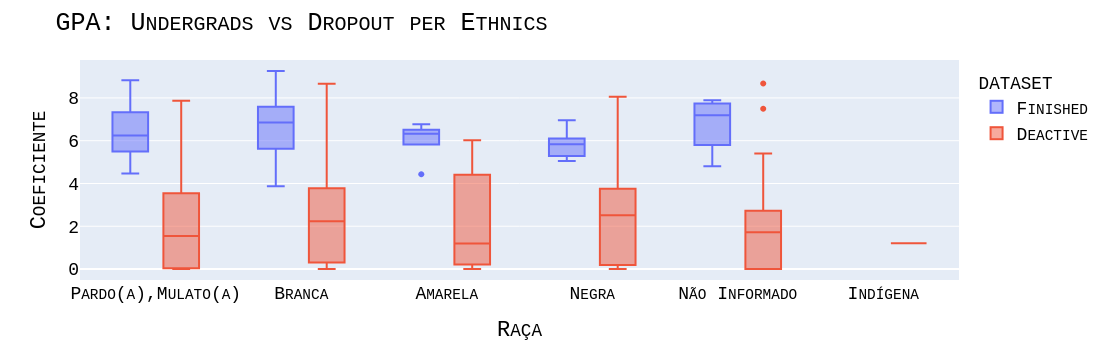

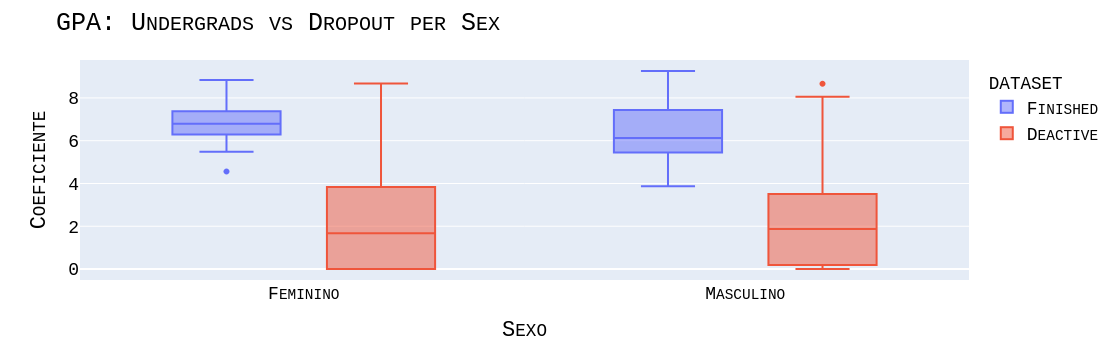

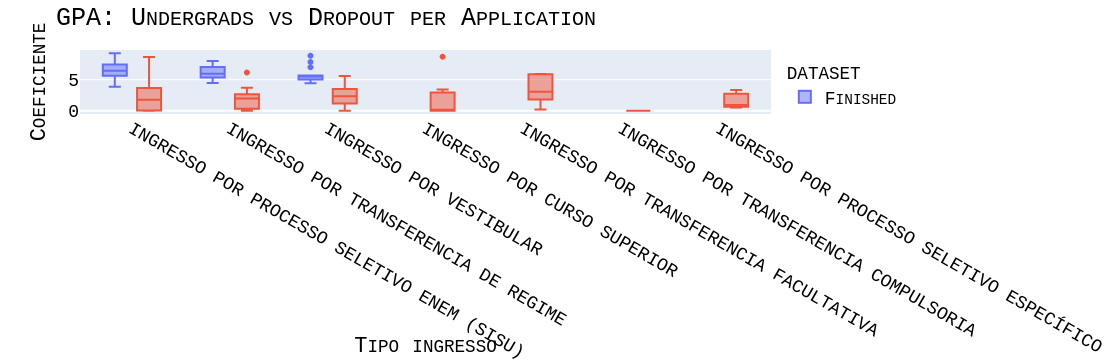

In [9]:
x = pd.concat([
        finished.assign(dataset="Finished"),
        dropout.assign(dataset="Deactive")])

px.box(x, x='Raça', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Ethnics"}, font=my_font).show()
px.box(x, x='Sexo', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Sex"}, font=my_font).show()
px.box(x, x='Tipo ingresso', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Application "}, font=my_font).show()


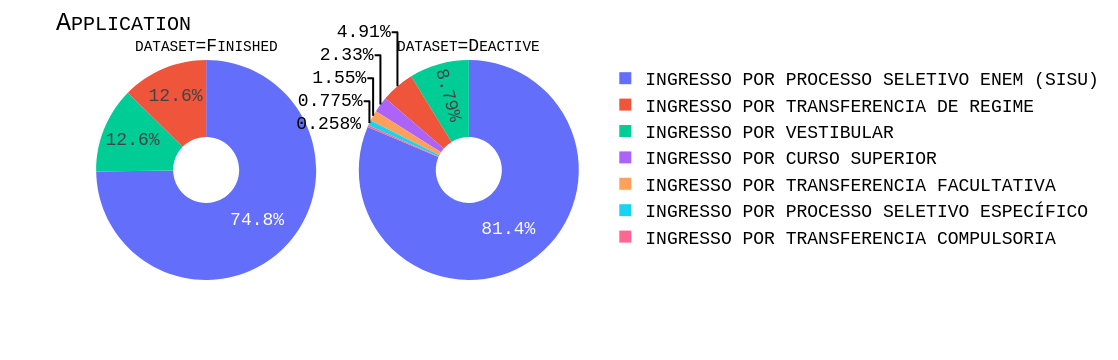

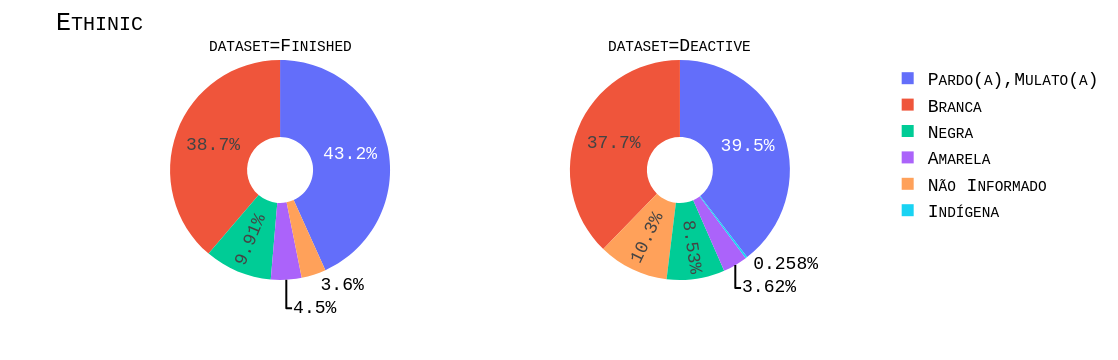

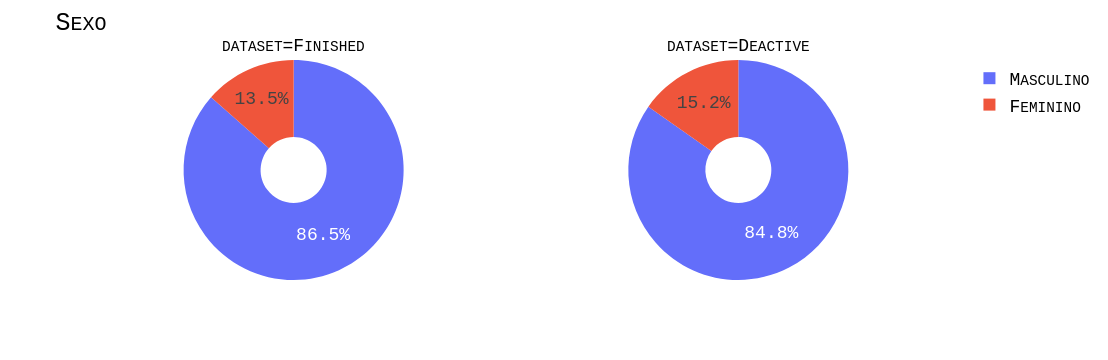

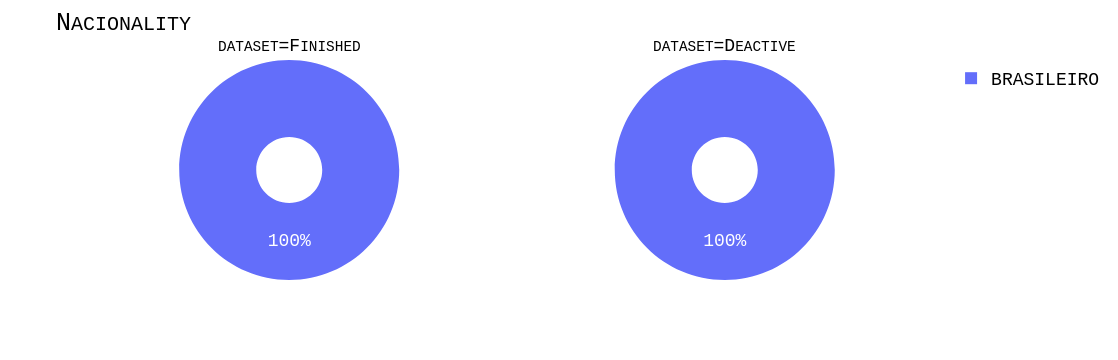

In [10]:
px.pie(
    x, 
    names='Tipo ingresso', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Application "},font=my_font).show()

px.pie(
    x, 
    names='Raça', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Ethinic "},font=my_font).show()


px.pie(
    x, 
    names='Sexo', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Sexo "},font=my_font).show()


px.pie(
    x, 
    names='Nacionalidade', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Nacionality "},font=my_font).show()

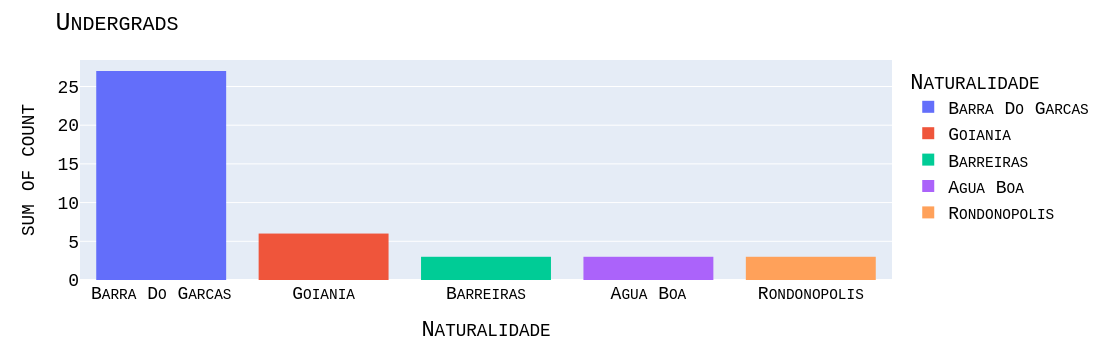

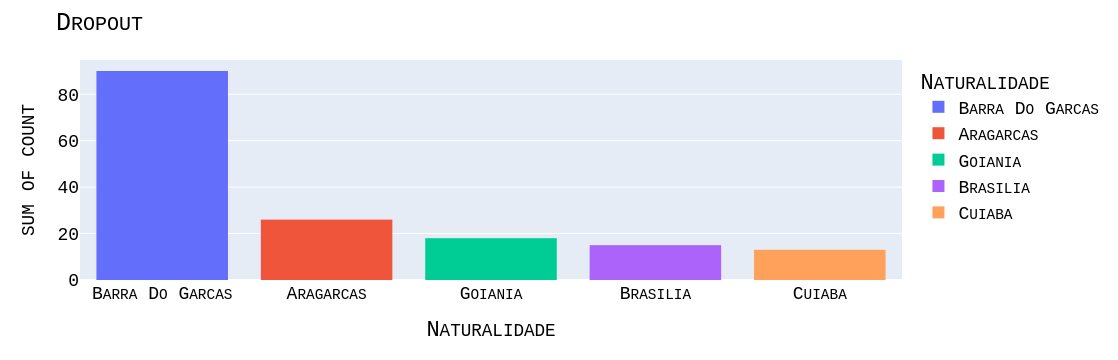

In [11]:
x_grouped =  finished.groupby(['Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y_grouped =  dropout.groupby(['Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
px.histogram(x_grouped.head(), x='Naturalidade', y='count', color='Naturalidade').update_layout(title={"text": "Undergrads"}, font=my_font).show()
px.histogram(y_grouped.head(), x='Naturalidade', y='count', color='Naturalidade').update_layout(title={"text": "Dropout"}, font=my_font).show()


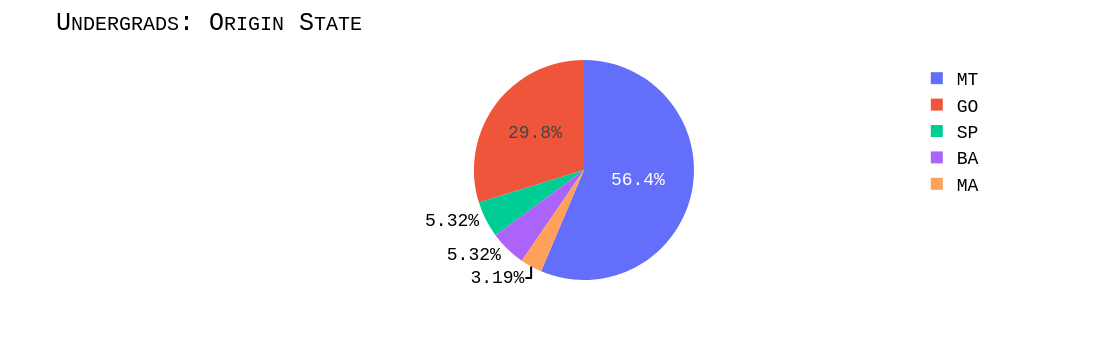

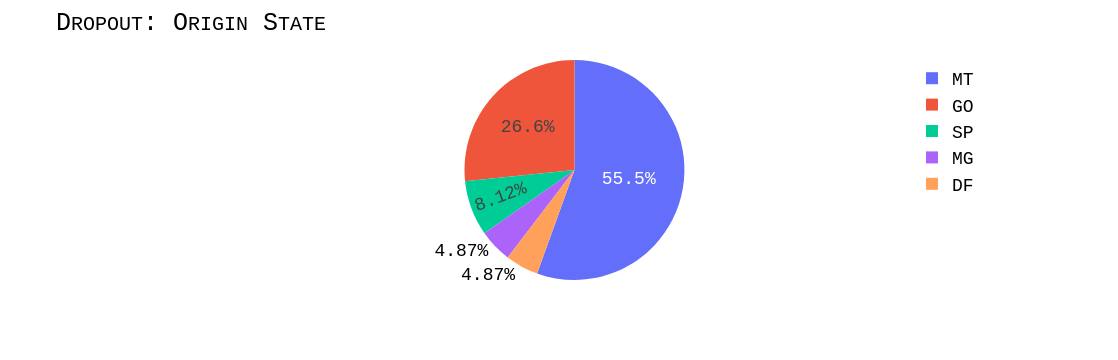

In [12]:
x_grouped =  finished.groupby(['UF Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y_grouped =  dropout.groupby(['UF Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
px.pie(x_grouped.head(), names='UF Naturalidade', values='count', color='UF Naturalidade').update_layout(title={"text": "Undergrads: Origin State"}, font=my_font).show()
px.pie(y_grouped.head(), names='UF Naturalidade', values='count', color='UF Naturalidade').update_layout(title={"text": "Dropout: Origin State"}, font=my_font).show()


## Analysing the years of entrance

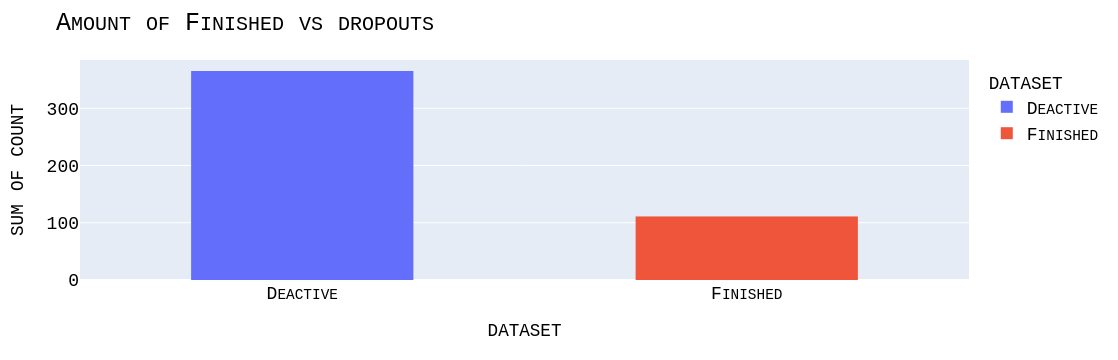

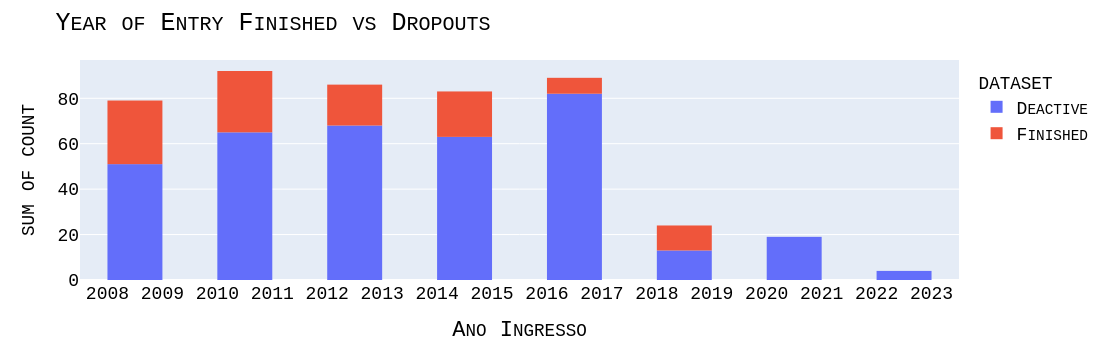

In [13]:
x = pd.concat([
        finished.assign(dataset="Finished"),
        dropout.assign(dataset="Deactive")])

test = x.copy()
# extracting the year of entrance
test = test[test['Período ingresso'] != 0]  # removing those with Período de Ingresso is zero 

test['Ano Ingresso'] = (test['Período ingresso'] / 10).astype("int")

x['Ano Ingresso'] = test['Ano Ingresso']

y = x.groupby(['Ano Ingresso', 'Sexo', 'dataset']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y = y[y['Ano Ingresso'] != 0] # making sure there are not the 22 zero values messing up the plot 
px.histogram(y, x='dataset', y='count', color='dataset').update_layout(bargap=0.5).update_layout(bargap=0.5, title={"text": "Amount of Finished vs dropouts"}, font=my_font).show()
px.histogram(y, x='Ano Ingresso', y='count', color='dataset').update_layout(bargap=0.5, title={"text": "Year of Entry Finished vs Dropouts"}, font=my_font).update_xaxes(tickmode='linear',dtick=1).show()


## Average time which someone evades

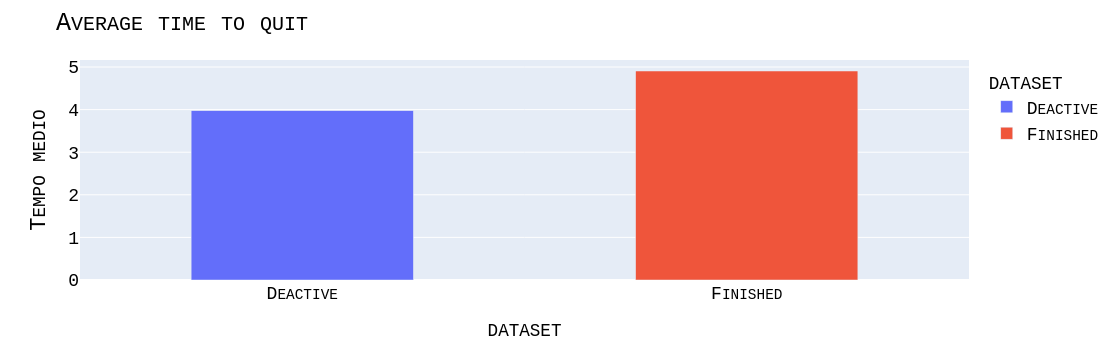

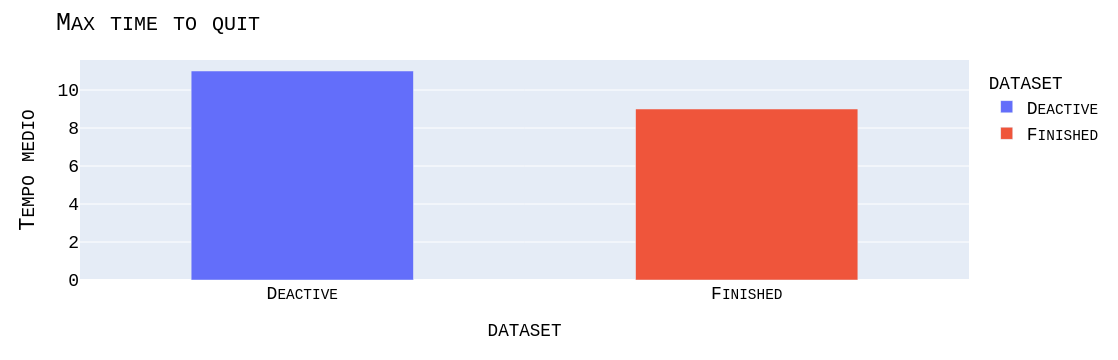

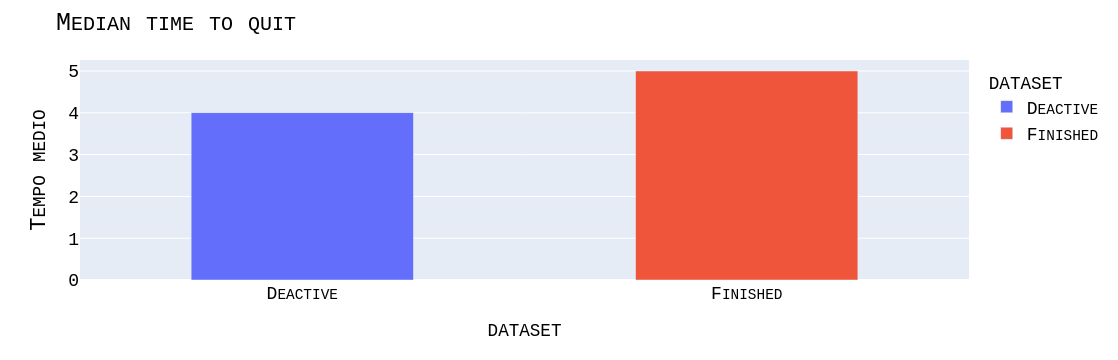

In [14]:
# let us do the math: If we subtract the period the person entered with the current period of the person, 
# we can get how much time they have spent in college 
test = test.dropna(subset=['Data ocorrência'])

test['Ano atual']  = np.where (
    test['Data ocorrência'].isnull(),
    (test['Período'] /10), 
     test['Data ocorrência'].str[:4].astype(float)) 
test['Ano atual'] = test['Ano atual'].fillna(0).astype(int)

test['Tempo medio'] = test['Ano atual'] - test['Ano Ingresso']

mean_time = test.groupby('dataset')['Tempo medio'].mean().reset_index()
min_time = test.groupby('dataset')['Tempo medio'].min().reset_index()
max_time = test.groupby('dataset')['Tempo medio'].max().reset_index()
median_time = test.groupby('dataset')['Tempo medio'].median().reset_index()


px.bar(mean_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Average time to quit"}, font=my_font).show()
px.bar(max_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Max time to quit"}, font=my_font).show()
px.bar(median_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Median time to quit"}, font=my_font).show()


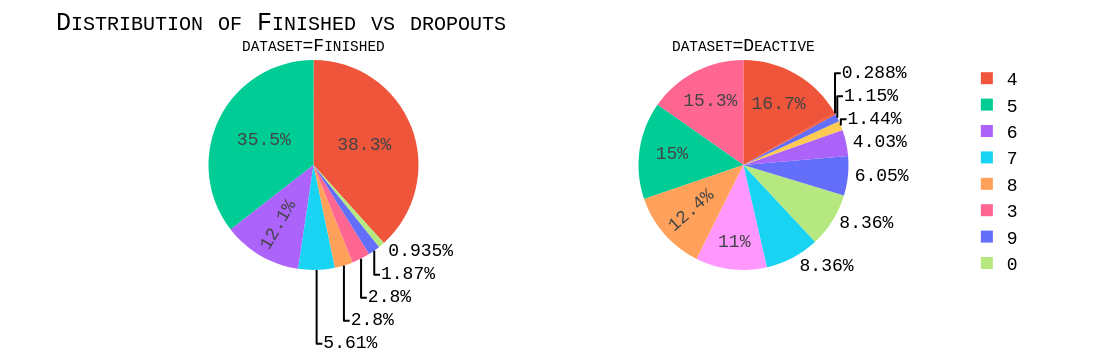

In [15]:
px.pie(test,
      names='Tempo medio',
      color='Tempo medio',
      facet_col='dataset').update_layout(bargap=0.5, title={"text": "Distribution of Finished vs dropouts"}, font=my_font).show()

In [16]:
y = test.groupby(['Sexo', 'dataset']).mean('Tempo medio').reset_index()
y

,Sexo,dataset,Período,Estrutura,Período ingresso,IMI,Coeficiente,Idade,Ano Ingresso,Ano atual,Tempo medio
0,Feminino,Deactive,20177.462963,20131.740741,20144.370370,15.992593,2.509630,24.454845,2014.333333,2017.870370,3.537037
1,Feminino,Finished,20158.857143,20098.142857,20116.714286,63.850000,6.837143,24.869472,2011.571429,2016.500000,4.928571
2,Masculino,Deactive,20176.873720,20123.764505,20138.249147,13.563140,2.281399,25.885128,2013.723549,2017.778157,4.054608
3,Masculino,Finished,20169.408602,20117.881720,20126.161290,76.582796,6.293333,24.579585,2012.516129,2017.419355,4.903226


## Analysing the history

In [176]:
df_merged = pd.merge(test,history, how='right', on='rga_anonimo')
second = df_merged.copy()
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19528 entries, 0 to 19527
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Data Nascimento       13470 non-null  object 
 1   Sexo                  13470 non-null  object 
 2   Raça                  13470 non-null  object 
 3   Estrangeiro           13470 non-null  object 
 4   Nacionalidade         13470 non-null  object 
 5   Naturalidade          13362 non-null  object 
 6   UF Naturalidade       12731 non-null  object 
 7   Período               13470 non-null  float64
 8   Situação atual        13470 non-null  object 
 9   Data ocorrência       13470 non-null  object 
 10  Estrutura             13470 non-null  float64
 11  Período ingresso      13470 non-null  float64
 12  Tipo ingresso         13470 non-null  object 
 13  IMI                   13470 non-null  float64
 14  Coeficiente           13470 non-null  float64
 15  Tipo de demanda    

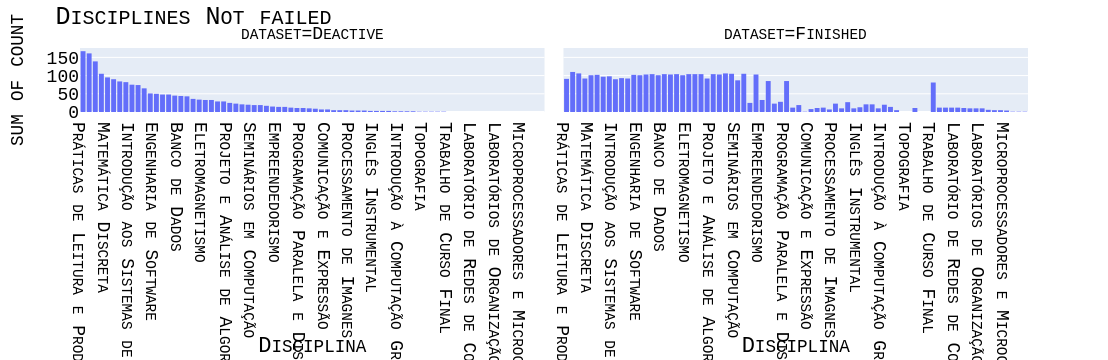

In [21]:
diciplines_grouped = df_merged[df_merged['SF'] == 'AP'] \
    .groupby(['dataset', 'Disciplina']) \
    .size() \
    .reset_index(name='count')\
    .sort_values( by='count', ascending=False)
px.histogram(diciplines_grouped, x='Disciplina', y='count', facet_col='dataset').update_layout(title={"text": "Disciplines Not failed"}, font=my_font) 


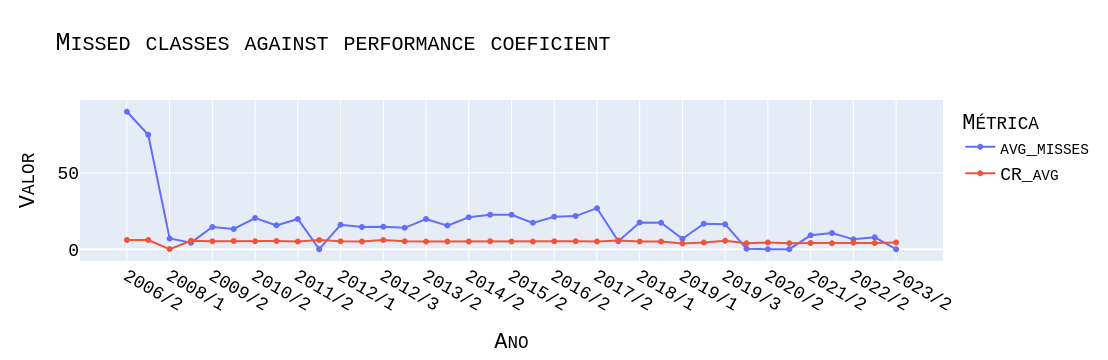

In [115]:
misses_avg = (
    df_merged.groupby("Ano")["FA"]
    .mean()
    .reset_index()
    .rename(columns={"FA": "avg_misses"})
)

cr_avg = (
    df_merged.groupby("Ano")["CR"]
    .mean()
    .reset_index()
    .rename(columns={"CR": "CR_avg"}) 
)

merged_2 = pd.merge(cr_avg, misses_avg, on='Ano')

merged_long = merged_2.melt(
    id_vars="Ano",
    value_vars=["avg_misses", "CR_avg"],
    var_name="Métrica",
    value_name="Valor"
)

fig = px.line(
    merged_long,
    x="Ano",
    y="Valor",
    color="Métrica",
    markers=True,
    title="Missed classes against performance coeficient"
).update_layout(font=my_font)

fig.show()


In [60]:
df_merged["Failing"] = df_merged["SF"].isin(["RM", "RMF"]).astype(int)

df_merged["Approved"] = (df_merged["SF"] == "AP").astype(int)

reprovations = (
    df_merged.groupby("rga_anonimo") 
    .agg(
        total_failings=("Failing", "sum"),
        total_approvals=("Approved", "sum"),
        total_disciplines=("SF", "count")
    )
    .reset_index()
)

reprovations

,rga_anonimo,total_failings,total_approvals,total_disciplines
0,005f0115277a00616dc1f82d6a8ab0dcab6dc9c9f5fc32...,27,4,31
1,006e15f692701bfe282277a51f8fd1db094c66124103bf...,27,5,40
2,021b585b6fc82a522e1d11157d544b3769e063a93c3514...,51,14,88
3,023d850bef6e9b93c3386b697f3989baa35cc0f80e796b...,10,1,13
4,02431d70ee922cfbe69d2551759d1e09a0e320f573a937...,9,0,11
...,...,...,...,...
659,ff6d8cd126eae345d6902eb6f02562314e67fa0cb9b06d...,5,0,5
660,ffa2e9fa2c153ef514ab273fd1a1f8c13cf331ca3a1317...,7,4,34
661,ffe443cf9a50f96acfebfdb60b402c0475175f373a37fb...,15,14,51
662,ffeb15c31366b2d5b58b2e9b3c567f7170ade5fda2cbb6...,22,6,85


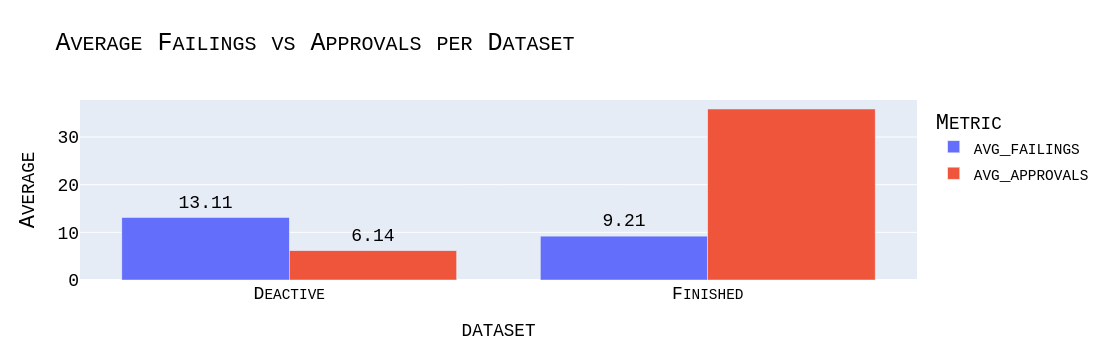

In [62]:
df_with_fails = pd.merge(
    df_merged[["rga_anonimo", "dataset"]].drop_duplicates(),
    reprovations,
    on="rga_anonimo",
    how="left"
)

avg_fails = (
    df_with_fails.groupby("dataset")["total_failings"]
    .mean()
    .reset_index()
    .rename(columns={"total_failings": "avg_failings"})
)

avg_approval = (
    df_with_fails.groupby("dataset")["total_approvals"]
    .mean()
    .reset_index()
    .rename(columns={"total_approvals": "avg_approvals"})
)


x_ = pd.merge(avg_fails, avg_approval, on='dataset')

x_long = x_.melt(
    id_vars="dataset",
    value_vars=["avg_failings", "avg_approvals"],
    var_name="Metric",
    value_name="Average"
)

px.bar(
    x_long,
    x="dataset",
    y="Average",
    color="Metric",
    barmode="group",
    text="Average",
    title="Average Failings vs Approvals per Dataset"
).update_layout(font=my_font).update_traces(texttemplate='%{text:.2f}', textposition='outside').show()


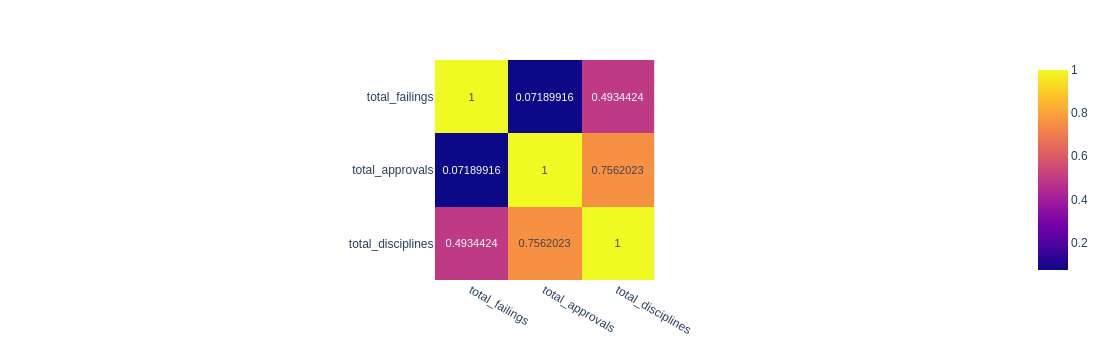

In [35]:
fig = px.imshow(df_with_fails.corr(numeric_only=True), text_auto=True).show()


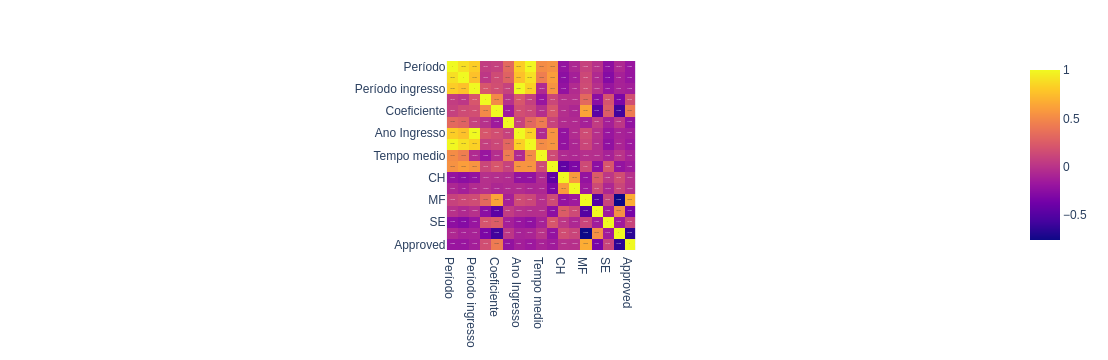

In [26]:
px.imshow(df_merged.corr(numeric_only=True), text_auto=True).show()


# From this it is possible to know the total amount of approved/failed subject for each student

In [65]:
reprovations = df_merged.groupby('rga_anonimo').agg(
        total_faillings=('Failing', 'sum'),
        total_approvals=('Approved', 'sum')      
)
reprovations['total_subjects_made'] = reprovations['total_faillings'] + reprovations['total_approvals']

In [106]:
x = reprovations.copy()
x['average_failing'] = ( reprovations['total_faillings'] / reprovations['total_subjects_made'] ) * 100
x['average_passing'] = ( reprovations['total_approvals'] / reprovations['total_subjects_made'] ) * 100


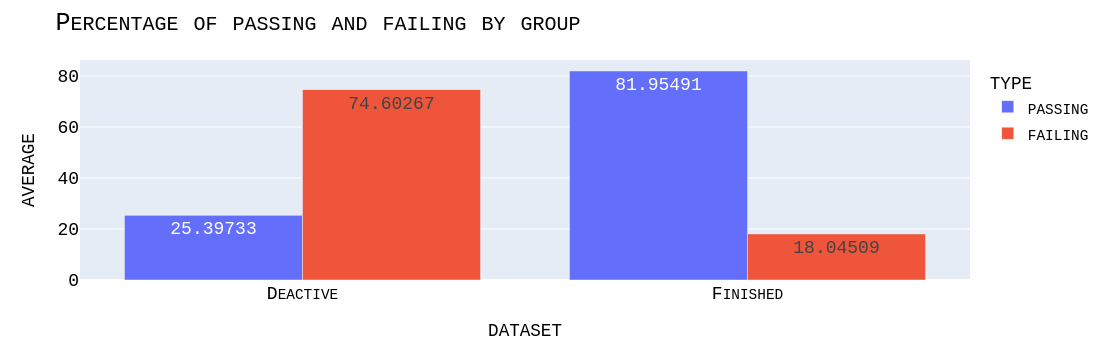

In [125]:
everyone_grouped = pd.merge(
    df_merged[['rga_anonimo', 'dataset', 'Sexo']].drop_duplicates(),
    x,
    on='rga_anonimo',
    how='inner'
)
y = everyone_grouped.groupby("dataset").agg( group_average_passing = ('average_passing', 'mean'),
                                             group_average_failing = ('average_failing', 'mean')).reset_index()
y_melted = y.melt(id_vars="dataset",
                  value_vars=["group_average_passing", "group_average_failing"],
                  var_name="type",
                  value_name="average")

y_melted["type"] = y_melted["type"].str.replace("group_average_", "")

px.bar(
    y_melted,
    x="dataset",
    y="average",
    color="type",
    barmode="group",
    text_auto=True
).update_layout(title={'text': 'Percentage of passing and failing by group'}, font=my_font).show()

## Now analysing the this percentage for each individual group like:
    - Gender
    - Quotas

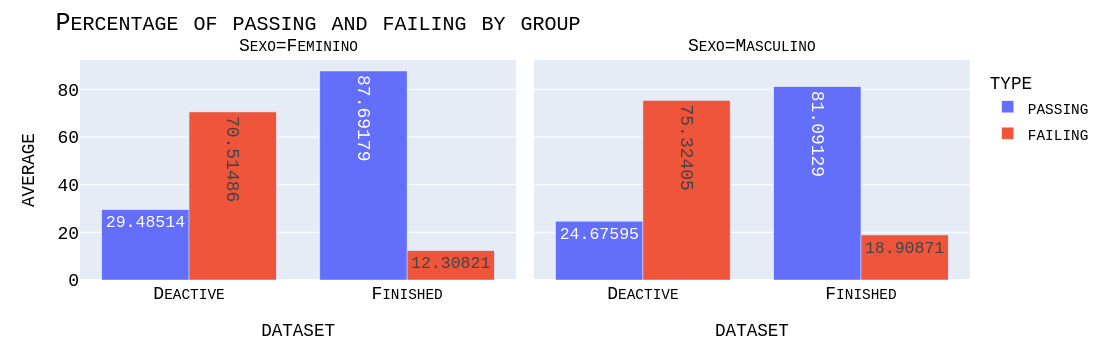

In [145]:
y = everyone_grouped.groupby(["Sexo","dataset"]).agg( group_average_passing = ('average_passing', 'mean'),
                                             group_average_failing = ('average_failing', 'mean')).reset_index()
y_melted = y.melt(id_vars=["Sexo", "dataset"],
                  value_vars=["group_average_passing", "group_average_failing"],
                  var_name="type",
                  value_name="average")

y_melted["type"] = y_melted["type"].str.replace("group_average_", "")

px.bar(
    y_melted,
    x="dataset",
    y="average",
    color="type",
    barmode="group",
    facet_col='Sexo',
    text_auto=True
).update_layout(title={'text': 'Percentage of passing and failing by group'}, font=my_font).show()

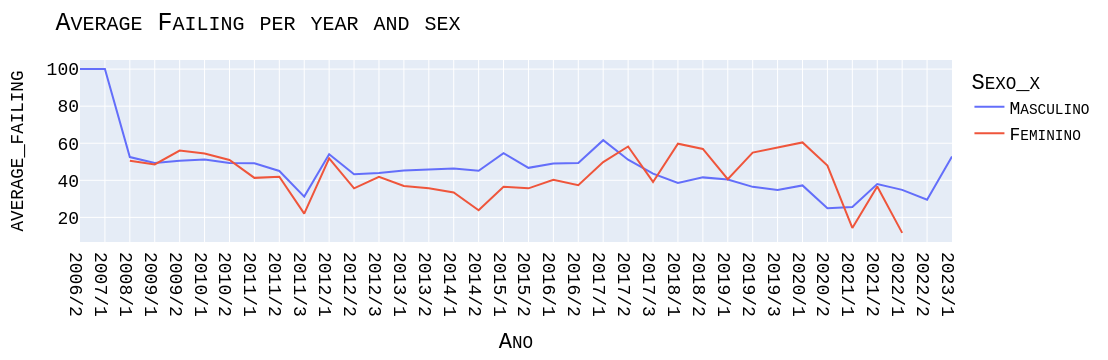

In [198]:
new = pd.merge(second, everyone_grouped, how='inner', on='rga_anonimo')
y = new.groupby(['Ano', 'Sexo_x'])['average_failing'].mean().reset_index()
px.line(y, x='Ano', y='average_failing', color='Sexo_x').update_layout(title={"text": 'Average Failing per year and sex'}, font=my_font)

In [216]:
old = new.copy()
old['Semester'] = old['Ano'].str.split("/").str[1].astype(int)
old['Parity'] = old['Semester'] % 2
old['Parity'] = old['Parity'].map({0: "even", 1: "odd"})
old.groupby('Parity')['total_faillings'].sum().reset_index()

,Parity,total_faillings
0,even,109443
1,odd,175138
